## 0. Getting Stared

Loading the Python Packages

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

Loading the Data: News Title

In [2]:
# Upload from the Computer
from google.colab import files
uploaded = files.upload()

Saving TSLA_Headlines.csv to TSLA_Headlines (1).csv


In [3]:
# Load the financial news data
news_titles = pd.read_csv('TSLA_Headlines.csv', encoding='windows-1250', header=None)
news_titles.columns = ['Title', 'Date']
news_titles.head()

,Title,Date
0,"Tesla: Nothing Matters, Until Everything Matters","Montana Skeptic•Yesterday, 1:56 PM•600 Comments"
1,Tesla: The Hype Does Not Reflect Reality,"The European View•Fri, Dec. 6•742 Comments"
2,Tesla Will Likely Achieve Record Deliveries In...,"iBEV•Wed, Dec. 4•340 Comments"
3,Tesla: Automatic Labeling For Computer Vision,"Trent Eady•Tue, Dec. 3•240 Comments"
4,Tesla: Ready To Re-Enter The Fast Lane,"DoctoRx•Tue, Dec. 3•229 Comments"


Loading the Data: Stock Prices

In [4]:
%%capture
!pip install yfinance

In [5]:
import yfinance as yf
prices = yf.download('TSLA', start='2017-12-11', end='2019-12-31')
prices.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-11,20.975332,21.934000,20.916668,21.927334,21.927334,119070000
2017-12-12,22.030001,22.762667,22.002001,22.735332,22.735332,130998000
2017-12-13,22.728666,22.948000,22.433332,22.601999,22.601999,93322500
2017-12-14,22.733999,23.162666,22.459999,22.525999,22.525999,86998500
2017-12-15,22.802668,22.926666,22.384001,22.896667,22.896667,103998000


## 1. Data Preprocessing

#### 1.1. News Sentiment Analysis

In [6]:
# transform date
from datetime import datetime
import re

news_titles['Date'][0] = 'Dec. 9' # modify the yesterday

newDateList = [] # create a list to store the cleaned dates

for dateOfArticles in news_titles['Date']: # loop every row in the "Date" column
  match = re.search(r'\w{3}\.\s\d{1,2}\,\s\d{4}|May\s\d{1,2}\,\s\d{4}|\w{3}\.\s\d{1,2}|May\s\d{1,2}', dateOfArticles)

  if re.search(r'\w{3}\.\s\d{1,2}\,\s\d{4}|\w{3}\s\d{1,2}\,\s\d{4}', match[0]):
    fulldate = match[0] # don't append year to string
  else:
    fulldate = match[0] + ", 2019" # append year to string
    
  for fmt in ('%b. %d, %Y', '%b %d, %Y'):
    try:
      newDate = datetime.strptime(fulldate, fmt).date()
      break # if format is correct, don't test any other formats
    except ValueError:
      pass
        
  newDateList.append(newDate) # add new date to the list

if(len(newDateList) != news_titles.shape[0]):
  print("Error: Rows don't match")
else:
  news_titles['New Date'] = newDateList # add the list to our original dataframe

news_titles.head()

,Title,Date,New Date
0,"Tesla: Nothing Matters, Until Everything Matters",Dec. 9,2019-12-09
1,Tesla: The Hype Does Not Reflect Reality,"The European View•Fri, Dec. 6•742 Comments",2019-12-06
2,Tesla Will Likely Achieve Record Deliveries In...,"iBEV•Wed, Dec. 4•340 Comments",2019-12-04
3,Tesla: Automatic Labeling For Computer Vision,"Trent Eady•Tue, Dec. 3•240 Comments",2019-12-03
4,Tesla: Ready To Re-Enter The Fast Lane,"DoctoRx•Tue, Dec. 3•229 Comments",2019-12-03


In [7]:
# vader sentiment analysis
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []

for headline in news_titles['Title']:
  pol_score = sia.polarity_scores(headline)
  pol_score['headline'] = headline
  results.append(pol_score)


news_titles['Sentiment Score'] = pd.DataFrame(results)['compound']

sentiment_scores = news_titles.groupby(['New Date']).sum() # creates a daily score by summing the scores of the individual articles in each day

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### 1.2. Trend and Technical Indicators

In [8]:
# Filling the Missing Data
prices = prices.fillna(method='ffill')

In [9]:
# Functions for Technical Indicators Calculation
# Technical Indicators: RSI, SMA, %K

def rsi(df, periods = 14, ema = True):
  """
  Returns a pd.Series with the relative strength index.
  """
  close_delta = df['Close'].diff()

  # Make two series: one for lower closes and one for higher closes
  up = close_delta.clip(lower=0)
  down = -1 * close_delta.clip(upper=0)
    
  if ema == True:
	  # Use exponential moving average
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
  else:
    # Use simple moving average
    ma_up = up.rolling(window = periods, adjust=False).mean()
    ma_down = down.rolling(window = periods, adjust=False).mean()
        
  rsi = ma_up / ma_down
  rsi = 100 - (100/(1 + rsi))
  return rsi

def sma(df, ndays = 14): 
  sma = pd.Series(df['Close'].rolling(ndays).mean()) 
  return sma

def stochastic_oscillator(df, periods = 14):
  high_roll = df['High'].rolling(periods).max()
  low_roll = df['Low'].rolling(periods).min()  
  # Fast stochastic indicator
  num = df['Close'] - low_roll
  denom = high_roll - low_roll
  K = (num / denom) * 100    
  return K

In [10]:
# Extract the Trend and Technical Indicators
prices['Today_Trend'] = np.where(prices['Close'] >= prices['Open'], 'uptrend', 'downtrend')
prices['Tomorrow_Trend'] = np.where(prices['Close'].shift(-1) >= prices['Close'], 'uptrend', 'downtrend')
prices['RSI'] = rsi(prices)
prices['SMA'] = sma(prices)
prices['%K'] = stochastic_oscillator(prices)
prices = prices[14:]
prices

,Open,High,Low,Close,Adj Close,Volume,Today_Trend,Tomorrow_Trend,RSI,SMA,%K
Date,,,,,,,,,,,
2018-01-02,20.799999,21.474001,20.733334,21.368668,21.368668,65283000,uptrend,downtrend,43.454184,21.873238,28.997411
2018-01-03,21.400000,21.683332,21.036667,21.150000,21.150000,67822500,downtrend,downtrend,40.543480,21.760000,20.343006
2018-01-04,20.858000,21.236668,20.378668,20.974667,20.974667,149194500,uptrend,uptrend,38.326659,21.643762,21.408013
2018-01-05,21.108000,21.149332,20.799999,21.105333,21.105333,68868000,downtrend,uptrend,40.919293,21.542286,26.552951
2018-01-08,21.066668,22.468000,21.033333,22.427334,22.427334,147891000,uptrend,downtrend,59.479121,21.508762,74.859928
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,27.452000,28.134001,27.333332,27.948000,27.948000,199794000,uptrend,uptrend,83.326865,24.480571,97.055707
2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500,uptrend,uptrend,84.352601,24.919714,99.776000
2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500,uptrend,downtrend,85.273271,25.398619,97.426818


#### 1.3. Merge the Data

In [11]:
df = pd.merge(prices, sentiment_scores[['Sentiment Score']], left_index=True, right_index=True, how='left')
df.fillna(0, inplace=True) # filling the missing sentiment scores with 0
df[10:16]

,Open,High,Low,Close,Adj Close,Volume,Today_Trend,Tomorrow_Trend,RSI,SMA,%K,Sentiment Score
Date,,,,,,,,,,,,
2018-01-17,22.698000,23.266666,22.650000,23.143999,23.143999,106552500,uptrend,downtrend,65.830343,21.779143,95.752515,-0.1280
2018-01-18,23.044666,23.486668,22.916000,22.971333,22.971333,85287000,downtrend,uptrend,62.802245,21.935952,83.419076,0.0000
2018-01-19,23.000000,23.372667,22.840000,23.334667,23.334667,73324500,uptrend,uptrend,66.313651,22.101000,95.109381,-0.0759
2018-01-22,23.293333,23.855333,23.280001,23.437332,23.437332,93156000,uptrend,uptrend,67.254281,22.292476,87.976952,0.0792
2018-01-23,24.000000,24.033333,23.400000,23.519333,23.519333,81981000,downtrend,downtrend,68.022336,22.446095,85.935785,-0.3870
2018-01-24,23.638666,23.650000,22.901333,23.059334,23.059334,79312500,downtrend,downtrend,59.580013,22.582476,73.349157,0.4215


In [12]:
# make a copy
data = df.copy()

#### 1.4. Encoding

In [13]:
data['Tomorrow Trend'] = np.where(data['Tomorrow_Trend'] == 'uptrend', 1, 0)
data['Today Trend'] = np.where(data['Today_Trend'] == 'uptrend', 1, 0)
#data['Today Uptrend'] = np.where(data['Today_Trend'] == 'uptrend', 1, 0)
#data['Today Downtrend'] = np.where(data['Today_Trend'] == 'downtrend', 1, 0)
data.drop(['Today_Trend',	'Tomorrow_Trend'], axis=1, inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,%K,Sentiment Score,Tomorrow Trend,Today Trend
Date,,,,,,,,,,,,
2018-01-02,20.799999,21.474001,20.733334,21.368668,21.368668,65283000,43.454184,21.873238,28.997411,0.0,0,1
2018-01-03,21.400000,21.683332,21.036667,21.150000,21.150000,67822500,40.543480,21.760000,20.343006,0.0,0,0
2018-01-04,20.858000,21.236668,20.378668,20.974667,20.974667,149194500,38.326659,21.643762,21.408013,0.0,1,1
2018-01-05,21.108000,21.149332,20.799999,21.105333,21.105333,68868000,40.919293,21.542286,26.552951,0.0,1,0
2018-01-08,21.066668,22.468000,21.033333,22.427334,22.427334,147891000,59.479121,21.508762,74.859928,0.0,0,1


## 2. Exploratory Data Analysis

In [14]:
# shape
data.shape

(502, 12)

In [15]:
# descriptive statistics
pd.set_option('precision', 3)
data.describe()

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,%K,Sentiment Score,Tomorrow Trend,Today Trend
count,502.000,502.000,502.000,502.000,502.000,5.020e+02,502.000,502.000,502.000,502.000,502.000,502.000
mean,19.656,20.026,19.288,19.675,19.675,1.332e+08,51.170,19.600,51.516,-0.045,0.494,0.534
std,3.163,3.226,3.119,3.178,3.178,7.285e+07,12.429,2.900,30.753,0.462,0.500,0.499
min,12.073,12.445,11.799,11.931,11.931,3.698e+07,20.460,12.956,0.225,-1.890,0.000,0.000
25%,17.172,17.474,16.809,17.187,17.187,8.596e+07,42.918,17.459,23.732,-0.273,0.000,0.000
50%,20.032,20.398,19.579,20.000,20.000,1.109e+08,49.284,19.762,52.080,0.000,0.000,1.000
75%,22.206,22.652,21.832,22.263,22.263,1.528e+08,58.230,22.136,80.218,0.126,1.000,1.000
max,29.000,29.021,28.423,28.729,28.729,5.047e+08,85.273,26.207,100.000,1.818,1.000,1.000


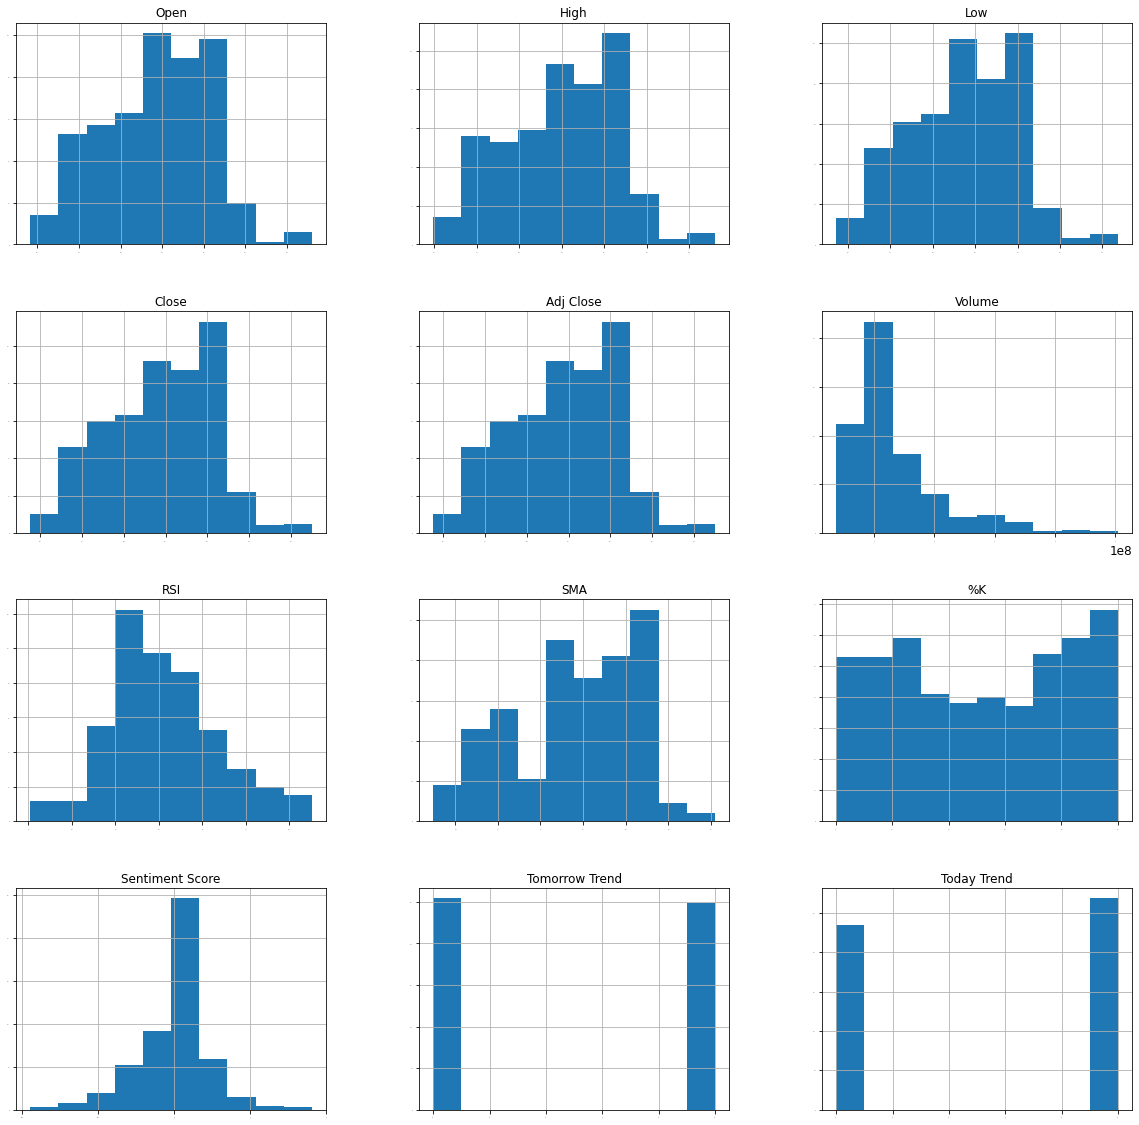

In [16]:
# Histogram
data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(20,20))
plt.show()

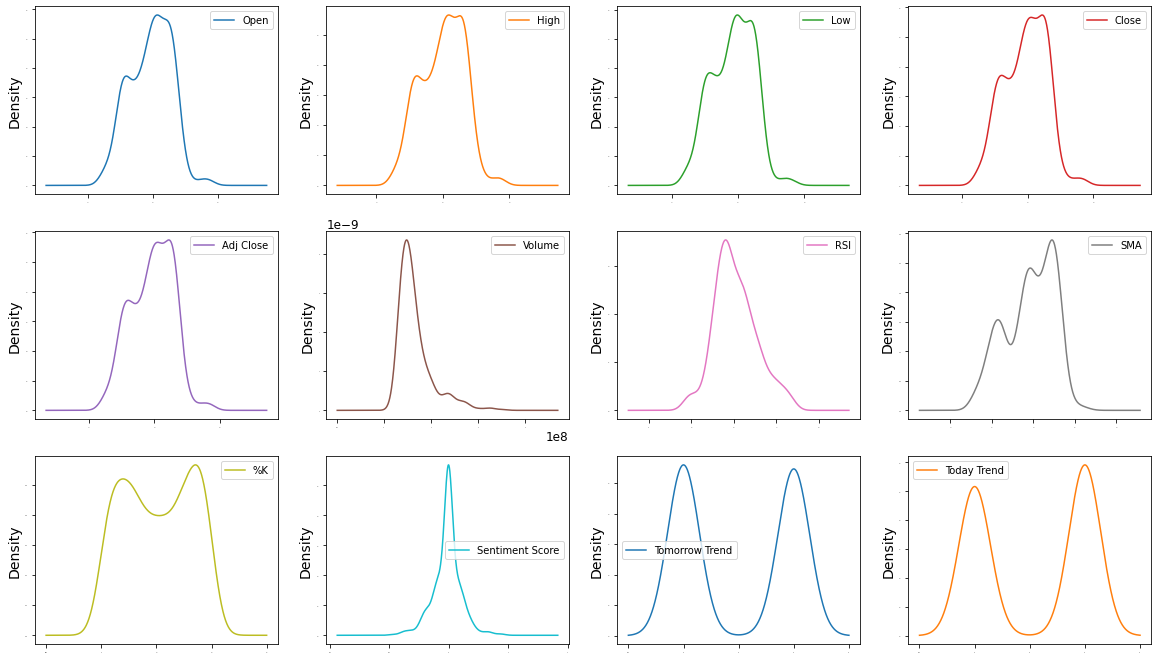

In [17]:
data.plot(kind='density', subplots=True, layout=(5,4), sharex=False, legend=True, fontsize=1, figsize=(20,20))
plt.show()

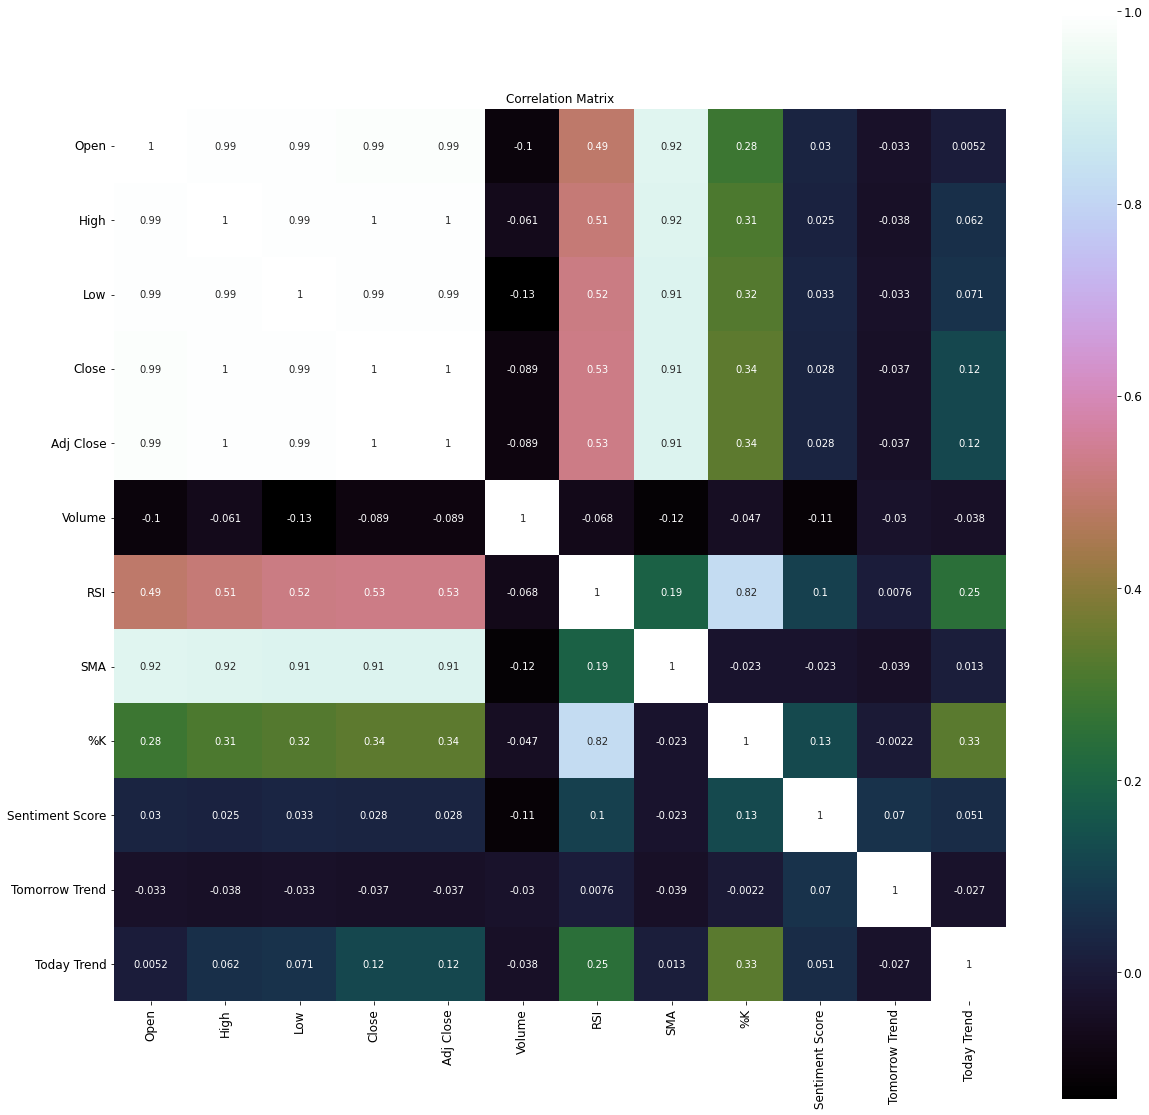

In [18]:
# Correlation
correlation = data.corr()
plt.figure(figsize=(20,20))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

<Figure size 1440x1440 with 0 Axes>

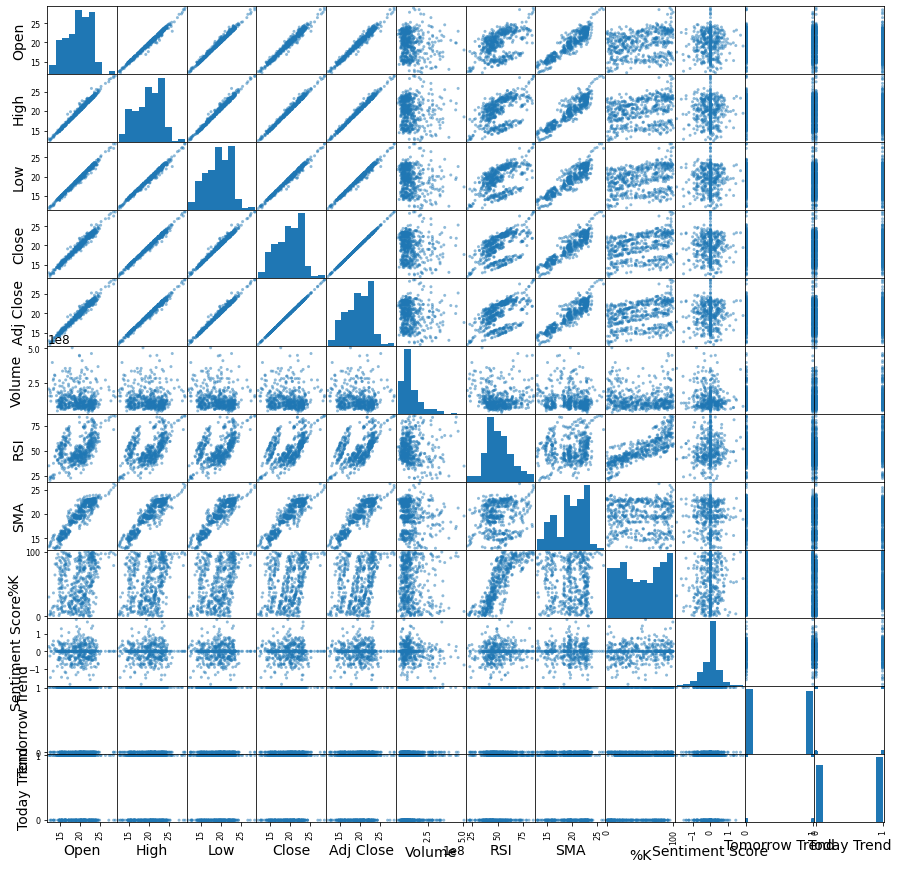

In [19]:
# Scatterplot Matrix
from pandas.plotting import scatter_matrix
plt.figure(figsize=(20,20))
scatter_matrix(data,figsize=(15,15))
plt.show()

## 3. Model Development

#### 3.1. Label and Features Selection

In [20]:
data.drop(['Open', 'Low', 'Adj Close'], axis=1, inplace=True)
y = data['Tomorrow Trend']
X = data.copy().drop("Tomorrow Trend", axis=1)

print(y.shape, X.shape)

(502,) (502, 8)


#### 3.2. Train Test Split 

In [21]:
X_train, X_test, y_train, y_test = X[:400], X[400:], y[:400], y[400:]

#### 3.2. Normalization

In [22]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

#### 3.3. Model Training

In [23]:
models = []
models.append(('RF', RandomForestClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('GBM', GradientBoostingClassifier()))

In [24]:
tscv = TimeSeriesSplit(n_splits=5)

results = []
names = []
for name, model in models:
  cv_results = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring="accuracy")
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

RF: 0.518182 (0.073231)
LR: 0.487879 (0.024242)
GBM: 0.490909 (0.015452)


#### 3.4. Hyperperameters Tuning

In [25]:
RF_param_search = {'n_estimators': [100, 200, 300], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [2, 3], 'criterion':['gini', 'entropy']}
LR_param_search = {'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'C': [10, 1.0, 0.1]}
GBM_param_search = {'n_estimators': [5,50,100,250], 'max_depth': [1, 3, 5, 7], 'learning_rate':[0.1,1,10,50]}

In [26]:
gsearch = GridSearchCV(estimator=GradientBoostingClassifier(), cv=tscv, param_grid=GBM_param_search)
gsearch.fit(X_train_scaled, y_train)
GBM_best_params = gsearch.best_params_
GBM_best_params

{'learning_rate': 10, 'max_depth': 3, 'n_estimators': 100}

In [27]:
gsearch = GridSearchCV(estimator=RandomForestClassifier(), cv=tscv, param_grid=RF_param_search)
gsearch.fit(X_train_scaled, y_train)
RF_best_params = gsearch.best_params_
RF_best_params

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [28]:
gsearch = GridSearchCV(estimator=LogisticRegression(), cv=tscv, param_grid=LR_param_search)
gsearch.fit(X_train_scaled, y_train)
LR_best_params = gsearch.best_params_
LR_best_params

{'C': 1.0, 'solver': 'liblinear'}

In [38]:
clfs = []
clfs.append(('RF', RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=3, max_features='sqrt')))
clfs.append(('LR', LogisticRegression(C=1.0, solver='liblinear')))
clfs.append(('GBM', GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=10)))

In [39]:
results = []
names = []
for name, clf in clfs:
  cv_results = cross_val_score(clf, X_train_scaled, y_train, cv=tscv, scoring="accuracy")
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

RF: 0.496970 (0.050160)
LR: 0.496970 (0.042207)
GBM: 0.527273 (0.055381)


## 4. Backtesting and Performance Evalustion

#### 4.1. In-Sample

In [40]:
# Confusion Matrix
for name, clf in clfs:
  clf.fit(X_train_scaled, y_train)
  y_train_pred = clf.predict(X_train_scaled)
  cm = confusion_matrix(y_train, y_train_pred)
  print(name, ":", cm)

RF : [[186  24]
 [ 89 101]]
LR : [[165  45]
 [144  46]]
GBM : [[165  45]
 [139  51]]


In [41]:
# Accuracy, Precision and Recall
names, accur, prec, rec, f1 = [], [], [], [], []
for name, clf in clfs:
  clf.fit(X_train_scaled, y_train)
  y_train_pred = clf.predict(X_train_scaled)
  clf_accur = accuracy_score(y_train, y_train_pred)
  clf_prec = precision_score(y_train, y_train_pred)
  clf_rec = recall_score(y_train, y_train_pred)
  clf_f1 = f1_score(y_train, y_train_pred)
  accur.append(clf_accur)
  prec.append(clf_prec)
  rec.append(clf_rec)
  f1.append(clf_f1)
  names.append(name)

In [42]:
insample_test = pd.DataFrame(list(zip(accur, prec, rec, f1)), index=names, columns=['accuracy scores', 'precision score', 'recall score', 'f1 score'])
insample_test

,accuracy scores,precision score,recall score,f1 score
RF,0.738,0.789,0.611,0.688
LR,0.527,0.505,0.242,0.327
GBM,0.540,0.531,0.268,0.357


#### 4.2. Out-Sample

In [43]:
X_test_scaled = scaler.transform(X_test)

In [44]:
# Confusion Matrix
for name, clf in clfs:
  clf.fit(X_train_scaled, y_train)
  y_test_pred = clf.predict(X_test_scaled)
  cm = confusion_matrix(y_test, y_test_pred)
  print(name, ":", cm)

RF : [[30 14]
 [39 19]]
LR : [[21 23]
 [27 31]]
GBM : [[34 10]
 [51  7]]


In [45]:
# Accuracy, Precision and Recall
names, accur, prec, rec, f1 = [], [], [], [], []
for name, clf in clfs:
  clf.fit(X_train_scaled, y_train)
  y_test_pred = clf.predict(X_test_scaled)
  clf_accur = accuracy_score(y_test, y_test_pred)
  clf_prec = precision_score(y_test, y_test_pred)
  clf_rec = recall_score(y_test, y_test_pred)
  clf_f1 = f1_score(y_test, y_test_pred)
  accur.append(clf_accur)
  prec.append(clf_prec)
  rec.append(clf_rec)
  f1.append(clf_f1)
  names.append(name)

outsample_test = pd.DataFrame(list(zip(accur, prec, rec, f1)), index=names, columns=['accuracy scores', 'precision score', 'recall score', 'f1 score'])
outsample_test

,accuracy scores,precision score,recall score,f1 score
RF,0.451,0.523,0.397,0.451
LR,0.510,0.574,0.534,0.554
GBM,0.402,0.412,0.121,0.187


## 5. Feature Importance

[0.17450274 0.13820379 0.12283063 0.11648702 0.17591065 0.12892251
 0.13194861 0.01119405]


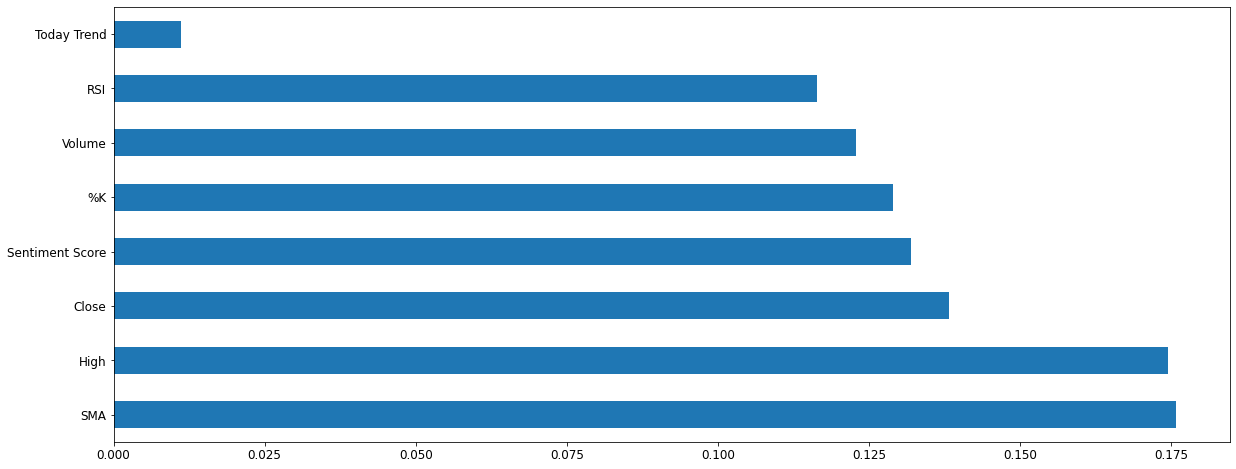

In [50]:
model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=2, max_features='sqrt')

# By calculating the node impurity, we can give a "score" to each feature measuring their importance.
model.fit(X_train_scaled,y_train)
print(model.feature_importances_) 
#use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize=(20,8))
plt.show()